# Homework 2 - IEEE Fraud Detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [0]:
# Taking all imports for processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: code and runtime results
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
# loading train-data in dataframes
train_identity_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/HomeWork/ieee-fraud-detection/train_identity.csv")
train_transaction_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/HomeWork/ieee-fraud-detection/train_transaction.csv")

# Since Part 1 to 5 would only involve following fields
# TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2
# Loading above necessary fields into base dataframe
# And performing EDA on these data
transaction_base_df = train_transaction_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                              "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                              "addr1", "addr2", "dist1", "dist2", "isFraud"]]
identity_base_df = train_identity_df[["TransactionID", "DeviceType", "DeviceInfo"]]

In [5]:
# Applying left join between transaction data and identity data,
# Since not all transactions will have corresponding identity data as per Kaggle description about the data-set
base_df = pd.merge(left=transaction_base_df, right=identity_base_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
base_df.shape

(590540, 15)

## Checking Duplicates across whole data-set
Testing whether there are any duplicates in the base data of transactions and devices.

---

Found that there are no duplicates since shape on `base_df[base_duplicates]` responds with 0 x 15


In [6]:
base_duplicates = base_df.duplicated()
base_df[base_duplicates].shape

(0, 15)

In [7]:
fraudulent_df = base_df[base_df.isFraud == 1]
non_fraudulent_df = base_df[base_df.isFraud == 0]
rows_in_fraud = fraudulent_df.shape[0]
rows_in_non_fraud = non_fraudulent_df.shape[0]
total_rows = base_df.shape[0]
print("Fraudulent instances: {0} | Non Fraudulent instances: {1}".format(str(rows_in_fraud), str(rows_in_non_fraud)))

Fraudulent instances: 20663 | Non Fraudulent instances: 569877


In [0]:
# Cite: https://stackoverflow.com/questions/41681693/pandas-isnull-sum-with-column-headers

## Checking Nulls and comparing between fraudulent and non-fraudulent data-set ##

In [9]:
# isnull() returns boolean array for each row
# sum() on isnull() groups null values and take their sum returning a Series
# the Series returned has null value for each column (which can be seen as index for that value in Series)
# In the end, we take transpose() to convert index to column and corresponding row in Series to cell Value for that column
non_fraudulent_null_stats = non_fraudulent_df.isnull().sum().sort_values(ascending=False).to_frame().transpose()
percent_non_fraud_nulls = non_fraudulent_null_stats * 100.0 / rows_in_non_fraud
non_fraudulent_null_stats

,dist2,DeviceInfo,R_emaildomain,DeviceType,dist1,P_emaildomain,addr2,addr1,card4,card6,isFraud,ProductCD,TransactionAmt,TransactionDT,TransactionID
0,535981,459818,443813,440278,336363,91666,57965,57965,1536,1532,0,0,0,0,0


In [10]:
fraudulent_null_stats = fraudulent_df.isnull().sum().sort_values(ascending=False).to_frame().transpose()
percent_fraud_nulls = fraudulent_null_stats * 100.0/ rows_in_fraud
fraudulent_null_stats

,dist2,dist1,DeviceInfo,DeviceType,R_emaildomain,addr2,addr1,P_emaildomain,card4,card6,isFraud,ProductCD,TransactionAmt,TransactionDT,TransactionID
0,16932,15908,12056,9452,9436,7741,7741,2790,41,39,0,0,0,0,0


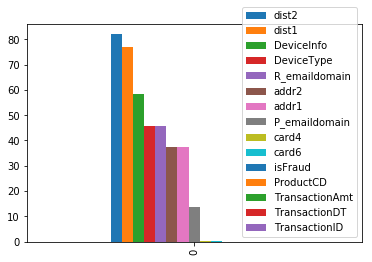

In [11]:
percent_fraud_nulls.plot.bar()

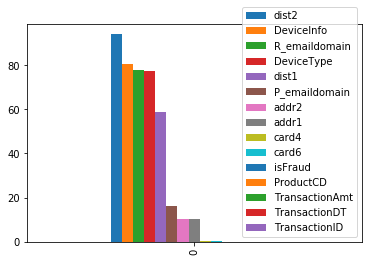

In [12]:
percent_non_fraud_nulls.plot.bar()

In [13]:
percent_fraud_nulls['tag'] = 'fraud'
percent_non_fraud_nulls['tag'] = 'non_fraud'
combined_percent_nulls = pd.concat([percent_fraud_nulls, percent_non_fraud_nulls], keys=['fraud', 'non_fraud'])
combined_percent_nulls

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,,DeviceInfo,DeviceType,P_emaildomain,ProductCD,R_emaildomain,TransactionAmt,TransactionDT,TransactionID,addr1,addr2,card4,card6,dist1,dist2,isFraud,tag
fraud,0,58.345836,45.743600,13.502396,0.0,45.666167,0.0,0.0,0.0,37.463098,37.463098,0.198422,0.188743,76.987853,81.943571,0.0,fraud
non_fraud,0,80.687236,77.258426,16.085225,0.0,77.878735,0.0,0.0,0.0,10.171493,10.171493,0.269532,0.268830,59.023789,94.052050,0.0,non_fraud


## Observation from visualization around null values in Fraud transactions and Non-Fraud transactions ##
1. Just like the non-fraud transactions, majority of null values in fraud transactions are from distances, devices and email addresses.
2. The key difference is in the field of `DeviceInfo` (Windows/Mac OS), `DeviceType` (mobile, desktop), `R_emaildomain` (receipient email).
  
    a. For fraud transaction `null` values for DeviceInfo is around 58% of its set, whereas for non-fraud transactions its around 80%. 
  
    b. For fraud transaction `null` values for DeviceType is around 45% of its set, whereas for non-fraud transaction its around 77%.
  
    c. Also receipent email address are `null` for 45% of its set, whereas for non-fraud transaction its 77%.
  
 One possible explanation for above discrepancy could be: the values for above details like email address are usually not provided or deferred by benevolent transactions, but a fraudster may have provided fake values instead of ignoring like a regular transactor. This in-turn reduced `null` values for fraud transactions.

## Observing distributions of fields among fraudulent and non-fraudulent transactions ##

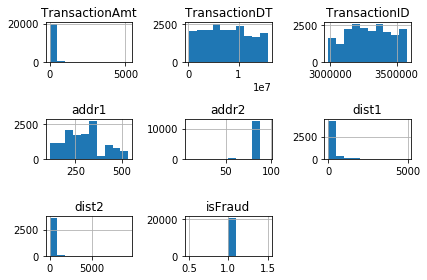

In [14]:
fraud_hists = fraudulent_df.hist()
plt.tight_layout()

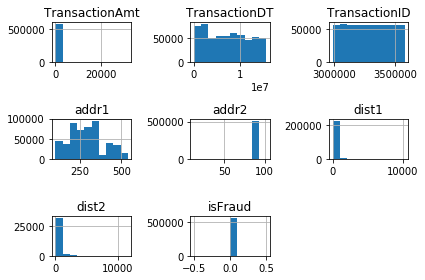

In [15]:
non_fraud_hists = non_fraudulent_df.hist()
plt.tight_layout()

## Conclusion ##
Apart from maximum frequency all histograms depict same kind of spread of values between fraudulent transactions and non-fraudulent transactions. The maximum frequency is different obviously because fraudulent transactions are only small fraction (~ 4%) of the global data-set

In [0]:
# https://stackoverflow.com/questions/51749208/plotting-two-histograms-from-a-pandas-dataframe-in-one-subplot-using-matplotlib

In [0]:
# figure, axes = plt.subplots(1,2)

# fraud_cut_df = fraudulent_df[fraudulent_df.TransactionAmt < 2000]
# non_fraud_cut_df = non_fraudulent_df[non_fraudulent_df.TransactionAmt < 2000]
# fraud_cut_df.TransactionAmt.hist(bins=30, ax=axes[0])
# non_fraud_cut_df.TransactionAmt.hist(bins=30, ax=axes[1])
# axes[0].set_title("fraud")
# axes[1].set_title("non_fraud")
# # plt.subplot(1,2,2)
# plt.tight_layout()

## Observing max-min-std of the fields among fraud vs non-fraud transactions ##

In [18]:
fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,2.066300e+04,2.066300e+04,20663.000000,12922.000000,12922.000000,4755.000000,3731.000000,20663.0
mean,3.294952e+06,7.690033e+06,149.244779,294.317134,86.286024,174.588854,201.472259,1.0
std,1.620403e+05,4.416551e+06,232.212163,103.584955,4.936238,424.232313,451.589576,0.0
min,2.987203e+06,8.976000e+04,0.292000,110.000000,10.000000,0.000000,0.000000,1.0
25%,3.167366e+06,3.965858e+06,35.044000,204.000000,87.000000,3.000000,7.000000,1.0
50%,3.291934e+06,7.575230e+06,75.000000,299.000000,87.000000,10.000000,49.000000,1.0
75%,3.428646e+06,1.121743e+07,161.000000,330.000000,87.000000,85.500000,233.000000,1.0
max,3.577526e+06,1.581088e+07,5191.000000,536.000000,96.000000,4942.000000,9337.000000,1.0


In [19]:
non_fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,5.698770e+05,5.698770e+05,569877.000000,511912.000000,511912.000000,233514.000000,33896.000000,569877.0
mean,3.281810e+06,7.360791e+06,134.511665,290.643341,86.813620,117.360098,235.199758,0.0
std,1.707548e+05,4.623930e+06,239.395078,101.692564,2.607742,370.641879,536.798492,0.0
min,2.987000e+06,8.640000e+04,0.251000,100.000000,13.000000,0.000000,0.000000,0.0
25%,3.133317e+06,3.010651e+06,43.970000,204.000000,87.000000,3.000000,7.000000,0.0
50%,3.281808e+06,7.271678e+06,68.500000,299.000000,87.000000,8.000000,36.000000,0.0
75%,3.429974e+06,1.125334e+07,120.000000,330.000000,87.000000,24.000000,206.000000,0.0
max,3.577539e+06,1.581113e+07,31937.391000,540.000000,102.000000,10286.000000,11623.000000,0.0


## Conclusion ##


1.   The max value of `TransactionAmt` for fraudulent transactions is 5191, whereas for non-fraudulent transaction it is 31937 (which is roughly 6 times). This suggests that fraudulent transactions are possibly done in smaller denominations may be to avoid flagging or alerting existing Fraud-Detection Systems 
2.   The max value of `dist1` for fraudulent transactions is 4942, whereas for non-fraudulent transaction it is 10286 (which is roughly twice). It suggests that either the fraudster did frauds at smaller distances or  fraudster recorded fake details regarding address or distances in their order details
3.   The standard deviation of `addr2` of fraudulent transactions is 4.93, whereas for non-fraudulent transactions is 2.6 (which is roughly half). This indicates that the spread of billing region or billing country details for fraudulent transactions is much higher may be because the fraudster were faking their details



## Part 2 - Transaction Frequency

In [20]:
# TODO: code to generate the frequency graph
base_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,5.905400e+05,5.905400e+05,590540.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000
mean,3.282270e+06,7.372311e+06,135.027176,290.733794,86.800630,118.502180,231.855423,0.034990
std,1.704744e+05,4.617224e+06,239.162522,101.741072,2.690623,371.872026,529.053494,0.183755
min,2.987000e+06,8.640000e+04,0.251000,100.000000,10.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,3.027058e+06,43.321000,204.000000,87.000000,3.000000,7.000000,0.000000
50%,3.282270e+06,7.306528e+06,68.769000,299.000000,87.000000,8.000000,37.000000,0.000000
75%,3.429904e+06,1.124662e+07,125.000000,330.000000,87.000000,24.000000,206.000000,0.000000
max,3.577539e+06,1.581113e+07,31937.391000,540.000000,102.000000,10286.000000,11623.000000,1.000000


### https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
### https://stackoverflow.com/questions/21441259/pandas-groupby-range-of-values

In [21]:
country_code_freq = base_df['addr2'].value_counts()
country_code_freq = country_code_freq.rename_axis('country_code').reset_index(name='country_transaction_counts')
country_code_freq.head()

,country_code,country_transaction_counts
0,87.0,520481
1,60.0,3084
2,96.0,638
3,32.0,91
4,65.0,82


### Maximum transaction country ###
We can see in the above step that the country with maximum transactions is the country having country-code, 87 (~ 88% of transactions).
So in the next step we observe the values of country with code 87. 

In [0]:
# max_transaction_dt = 15811130
max_transaction_dt = 16000000
transaction_bin_width = 86400 
most_frequent_country = base_df[base_df.addr2 == 87]
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(most_frequent_country["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
dayWiseTransactionCount = most_frequent_country.groupby(row_bin_tags).agg(['count'])["TransactionID"]

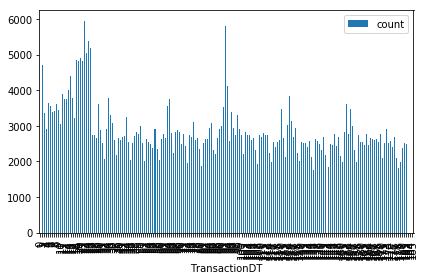

In [51]:
dayWiseTransactionCount.plot.bar()
plt.tight_layout()

In [0]:
max_transaction_dt = 16000000
transaction_bin_width = 86400 
most_frequent_country = base_df[base_df.addr2 == 87]
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(most_frequent_country["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
dayWiseTransactionCount = most_frequent_country.groupby(row_bin_tags).agg(['count'])["TransactionID"]

As you can see, majority of the transactions were done in the earlier days in the time frame. There are only few outliers (a day or two) in the six month time frame

## Part 3 - Product Code

In [0]:
# TODO: code to analyze prices for different product codes

Write your answer here

## Part 4 - Correlation Coefficient

In [0]:
# TODO: code to calculate correlation coefficient

Write your answer here

## Part 5 - Interesting Plot

In [0]:
# TODO: code to generate the plot here.

Write your answer here

## Part 6 - Prediction Model

In [0]:
# TODO: code for your final model

Write your answer here

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: FILL HERE

Highest Rank: FILL HERE

Score: FILL HERE

Number of entries: FILL HERE

INCLUDE IMAGE OF YOUR KAGGLE RANKING